In [1]:
#EP Phys 512
#Question 3

In [2]:
import corner
import numpy as np
import matplotlib.pyplot as mpl
from wmap_camb_example import get_spectrum

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

In [3]:
#STEPS:

#STEP 1: determine how big of a step to take for the derivative
    #find noise matrix N
    #first guess for derivative matrix Am
    #second derivative matrix AmT N-1 Am
    
    #then use either:
    #Lemma 11.13 from https://www.uio.no/studier/emner/matnat/math/MAT-INF1100/h10/kompendiet/kap11.pdf
    #or simon's way:
    #dx = sqrt(diag(curvature^-1))*0.1
    
#STEP 2: 
    #enter parameters and derivative dx size into function
    #return point and derivatives Am at that point
    
#STEP 3:
    #calculate new step size and chi2
    #calculate new derivative dx size from matrix Am

#STEP 4:
    #iterate steps 2 and 3 until stopping criterea met
    #ie step size < param*10**(-2) or change in chi2 < 10**(-2)


In [4]:
#return the value and the derivative matrix for all the parameters, tau optional
#still need to pass in all parameters
#have default dx for first iteration
def value_and_deriv(pars0, dx, tau=True):
    
    y1 = get_spectrum(pars0)
    dpars = np.zeros((len(y1), len(pars0)))
    
    for ii in range(0, len(pars0)):
        pars = np.copy(pars0)
        pars[ii] += dx[ii]       #add the derivative to a single parameter
        
#         print('running with pars ', pars)
        y2 = get_spectrum(pars)
        
        dpars[:, ii] = (y2-y1)/dx[ii]
    
    #clip to match data
    y1 = y1[2:1199+2]
    dpars = dpars[2:1199+2, :]
    
    if tau: #if we want to be setting tau as well
        return y1, dpars
    
    #otherwise cut out the tau derivative information
    dpars = np.concatenate( (dpars[:, 0:3], dpars[:, 4:6]), axis=1 )
    return y1, dpars
    

In [5]:
#return the value and the derivative matrix for ONLY TAU
#still need to pass in all parameters
#have default dx for first iteration
def value_and_deriv_only_tau(pars0, dx, tau=True):
    
    y1 = get_spectrum(pars0)
    dpars = np.zeros((len(y1))) #only need one in the array
    
    for ii in [3]: #literally only doing tau
        pars = np.copy(pars0)
        pars[ii] += dx[ii]       #add the derivative to a single parameter
        
#         print('running with pars ', pars)
        y2 = get_spectrum(pars)
        
        dpars = (y2-y1)/dx[ii]
    
    #clip to match data
    y1 = y1[2:1199+2]
    dpars = dpars[2:1199+2]
    
    return y1, dpars

In [6]:
### FIRST RUN THROUGH: VARY ALL PARAMETERS EXCEPT TAU ###

pars0 = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
dx0 = pars0 / 10**3 #first guess at derivative dx about a thousands of the values
wmap = np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
tau = False

#create N matrix. make inverse
Ninv = np.diag(1/wmap[:,2]**2) #1/sig**2, diagonal matrix

#first iteration, guess at dx0 and refine it
cmb, Am = value_and_deriv(pars0, dx0, tau)
print(cmb.shape)
print(Am.shape)

#using about a tenth of the error in curvature to say how big derivative steps should be
dx = 0.1*np.sqrt(np.diag( np.linalg.inv((Am.T@Ninv@Am)) ))
if tau==False: #matrix will be smaller, need to plug a 0 in there
    dx = np.insert(dx, 3, 0) #add a zero to the third index

print('dx for derivatives will be', dx)

num_iters = 10
pars = np.copy(pars0) #deep copy.
chi2 = np.zeros(num_iters) #save the chi2 info

#iterate though.
for ii in range(num_iters):
    y, Am = value_and_deriv(pars, dx, tau)
    resid = wmap[:,1] - y
    rhs = Am.T@(Ninv@resid)
    lhs = Am.T@Ninv@Am
    
    step = np.linalg.inv(lhs)@rhs
    dx = 0.1*np.sqrt(np.diag( np.linalg.inv((lhs)) )) #grab a new derivative step size
    
    if tau==False: #matrix will be smaller, need to plug a value in there
        dx = np.insert(dx, 3, 0.01) #add some value to the third index
        step = np.insert(step, 3, 0) #step must be zero, don't want to move tau
        
    pars += step

    chi2[ii] = resid.T@Ninv@resid
    print('done iteration ', ii, ' next step will be ', step)
    print('chi2 is ', chi2[ii])
    
    #check difference in chi2
    if ii > 0:
        delchi2 = chi2[ii-1]-chi2[ii]
        print('delchi2 is ', delchi2)
        if np.abs(delchi2) < 0.01:
            print('change in chi les than 0.01, exiting loop')
            break

(1199,)
(1199, 5)
dx for derivatives will be [2.43274559e-01 5.30750085e-05 5.12178772e-04 0.00000000e+00
 4.24191160e-12 1.33515469e-03]


/home/elizabeth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


done iteration  0  next step will be  [2.41289111e+00 2.47298283e-03 1.62039760e-02 0.00000000e+00
 6.90897458e-11 6.81006141e-03]
chi2 is  1588.237645861889
done iteration  1  next step will be  [ 1.87585901e+00  2.08020088e-05 -2.23277350e-03  0.00000000e+00
 -2.61024843e-11  2.92430300e-03]
chi2 is  1234.307766392786
delchi2 is  353.92987946910284
done iteration  2  next step will be  [ 4.62611699e-02 -2.42655877e-06 -8.35449555e-05  0.00000000e+00
 -6.64828305e-13  5.13184301e-05]
chi2 is  1227.937192027052
delchi2 is  6.370574365734001
done iteration  3  next step will be  [ 1.54518611e-04 -1.74432104e-07 -1.25736616e-06  0.00000000e+00
 -1.47018482e-14 -2.65730611e-06]
chi2 is  1227.9356705454006
delchi2 is  0.0015214816514799168
change in chi les than 0.01, exiting loop


Done fit with 5 parameters and tau fixed.
Final parameters:  [6.93351658e+01 2.24911838e-02 1.13886400e-01 5.00000000e-02
 2.04230773e-09 9.69783026e-01]
Final errors:  [2.40644074e+00 5.41095732e-04 5.24264784e-03 3.89551838e-11
 1.36333897e-02]


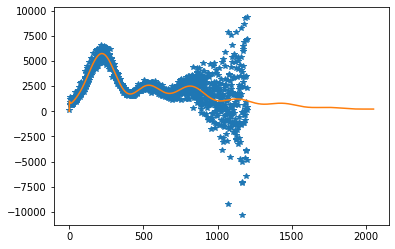

In [7]:
#examining the parameter fits
final_params = np.copy(pars) #pars will be overwritten later, keep as safe copy
final_params_errs = np.sqrt(np.diag(np.linalg.inv(lhs)))
print('Done fit with 5 parameters and tau fixed.')
print('Final parameters: ', final_params)
print('Final errors: ', final_params_errs)

cmb_bestfit = get_spectrum(final_params)

mpl.figure()
mpl.plot(wmap[:,0], wmap[:,1], '*') #plot data
mpl.plot(cmb_bestfit)
mpl.show()

In [8]:
### STEP 2: KEEP PARAMETERS AT BEST FIT, AND VARY ONLY TAU

tau = True
dx0 = pars / 10**3 #first guess at derivative dx about a thousands of the values

#first iteration, guess at dx0 and refine it
cmb, Am = value_and_deriv(pars, dx0, tau)

#using about a tenth of the error in curvature to say how big derivative steps should be
dx = 0.1*np.sqrt(np.diag( np.linalg.inv((Am.T@Ninv@Am)) ))
print('dx for derivatives will be', dx)


num_iters = 10
pars = np.copy(final_params)
chi2 = np.zeros(num_iters)

#iterate though.
for ii in range(num_iters):
    y, Am = value_and_deriv(pars, dx, tau)
    resid = wmap[:,1] - y
    rhs = Am.T@(Ninv@resid)
    lhs = Am.T@Ninv@Am
    
    step = np.linalg.inv(lhs)@rhs
    dx = 0.1*np.sqrt(np.diag( np.linalg.inv((lhs)) )) #grab a new derivative step size
    print('pars are ', pars)
    
    pars[3] += step[3] #we actually only want to increment tau
    

    chi2[ii] = resid.T@Ninv@resid
    print('done iteration ', ii, ' next step will be ', step)
    print('chi2 is ', chi2[ii])
    
    #check difference in chi2
    if ii > 0:
        delchi2 = chi2[ii-1]-chi2[ii]
        print('delchi2 is ', delchi2)
        if np.abs(delchi2) < 0.01:
            print('change in chi les than 0.01, exiting loop')
            break

dx for derivatives will be [3.67152344e-01 8.52424920e-05 7.04619022e-04 1.49322046e-02
 5.93284930e-11 2.62201985e-03]
pars are  [6.93351658e+01 2.24911838e-02 1.13886400e-01 5.00000000e-02
 2.04230773e-09 9.69783026e-01]
done iteration  0  next step will be  [-1.20410464e-01 -2.84306605e-05  2.02864684e-04 -5.70446707e-03
 -2.21972458e-11 -9.67294219e-04]
chi2 is  1227.9356745064342
pars are  [6.93351658e+01 2.24911838e-02 1.13886400e-01 4.42955329e-02
 2.04230773e-09 9.69783026e-01]
done iteration  1  next step will be  [-2.16390586e-01 -5.18734642e-05  3.62823385e-04 -6.02865299e-03
 -4.60885579e-11 -1.74901366e-03]
chi2 is  1237.717484645321
delchi2 is  -9.78181013888684
pars are  [6.93351658e+01 2.24911838e-02 1.13886400e-01 3.82668799e-02
 2.04230773e-09 9.69783026e-01]
done iteration  2  next step will be  [-3.52388966e-01 -8.47403739e-05  5.91188885e-04 -9.11064861e-03
 -8.18569415e-11 -2.83863632e-03]
chi2 is  1269.862408043946
delchi2 is  -32.144923398625
pars are  [6.933516

Done fit with only tau varying.
Final parameters:  [6.93351658e+01 2.24911838e-02 1.13886400e-01 2.32378189e-02
 2.04230773e-09 9.69783026e-01]
Final errors:  [3.34424648e+00 7.78710355e-04 6.49442204e-03 1.48073561e-01
 5.82123564e-10 2.33183175e-02]


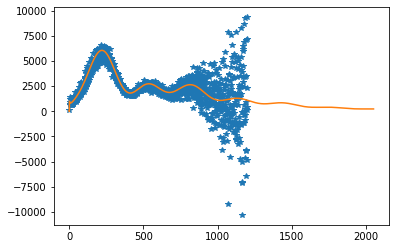

In [9]:
#examining the parameter fits
final_params_tau = np.copy(pars) #pars will be overwritten later, keep as safe copy
final_params_errs_tau = np.sqrt(np.diag(np.linalg.inv(lhs)))
print('Done fit with only tau varying.')
print('Final parameters: ', final_params_tau)
print('Final errors: ', final_params_errs_tau)

cmb_bestfit_tau = get_spectrum(final_params_tau)

mpl.figure()
mpl.plot(wmap[:,0], wmap[:,1], '*') #plot data
mpl.plot(cmb_bestfit_tau)
mpl.show()

In [10]:
#RUN AGAIN TO GET GOOD CURVATURE MATRIX: run with best parameters and tau=0.05
#produce ENTIRE curvature matrix

#use previous final parameters, which were 'pars'
pars = np.copy(final_params)
dx0 = pars / 10**3 #first guess at derivative dx about a thousands of the values
tau = True

#first iteration, guess at dx0 and refine it
cmb, Am = value_and_deriv(pars0, dx0, tau)

#using about a tenth of the error in curvature to say how big derivative steps should be
dx = 0.1*np.sqrt(np.diag( np.linalg.inv((Am.T@Ninv@Am)) ))
if tau==False: #matrix will be smaller, need to plug a 0 in there
    dx = np.insert(dx, 3, 0) #add a zero to the third index

print('dx for derivatives will be', dx)

num_iters = 10
chi2 = np.zeros(num_iters)

#iterate though.
for ii in range(num_iters):
    y, Am = value_and_deriv(pars, dx, tau)
    resid = wmap[:,1] - y
    rhs = Am.T@(Ninv@resid)
    lhs = Am.T@Ninv@Am
    
    step = np.linalg.inv(lhs)@rhs
    dx = 0.1*np.sqrt(np.diag( np.linalg.inv((lhs)) )) #grab a new derivative step size
    
    if tau==False: #matrix will be smaller, need to plug a value in there
        dx = np.insert(dx, 3, 0.01) #add some value to the third index
        step = np.insert(step, 3, 0) #step must be zero, don't want to move tau
        
    pars += step

    chi2[ii] = resid.T@Ninv@resid
    print('done iteration ', ii, ' next step will be ', step)
    print('chi2 is ', chi2[ii])
    
    #check difference in chi2
    if ii > 0:
        delchi2 = chi2[ii-1]-chi2[ii]
        print('delchi2 is ', delchi2)
        if np.abs(delchi2) < 0.01:
            print('change in chi les than 0.01, exiting loop')
            break

dx for derivatives will be [3.56271206e-01 7.80703465e-05 6.66405897e-04 1.45526301e-02
 5.66984762e-11 2.48645724e-03]
done iteration  0  next step will be  [-1.24723239e-01 -2.92891578e-05  2.11107322e-04 -5.90011910e-03
 -2.29546832e-11 -9.98163828e-04]
chi2 is  1227.9356745064342
done iteration  1  next step will be  [-9.41868993e-02 -2.36179148e-05  1.53529578e-04 -5.90209562e-03
 -2.31720906e-11 -7.75845954e-04]
chi2 is  1227.929380683347
delchi2 is  0.006293823087162309
change in chi les than 0.01, exiting loop


In [11]:
print(pars)
par_errs2 = np.sqrt(np.diag(np.linalg.inv(lhs)))
print(par_errs2)

[6.91162557e+01 2.24382768e-02 1.14251037e-01 3.81977853e-02
 1.99618096e-09 9.68009016e-01]
[3.72050854e+00 8.63940293e-04 7.15760479e-03 1.53078691e-01
 5.91976432e-10 2.67853773e-02]


In [12]:
print(Am)
print(lhs)

[[ 1.50236101e+01 -3.68771218e+03 -3.85769584e+03  3.18489374e+02
   5.00103547e+11 -4.75887270e+03]
 [ 1.13643563e+01 -3.07364302e+03 -2.88439592e+03  1.66547732e+02
   4.70180522e+11 -4.28338294e+03]
 [ 8.82721237e+00 -2.52644940e+03 -2.21931862e+03 -4.80222620e+01
   4.43253572e+11 -3.88160048e+03]
 ...
 [-1.48517935e+01  1.01456505e+04 -7.48258626e+03 -2.08655429e+03
   5.19165831e+11  7.24014623e+02]
 [-1.49468870e+01  1.02419856e+04 -7.50374683e+03 -2.07799757e+03
   5.17222878e+11  7.21857174e+02]
 [-1.50365942e+01  1.03331274e+04 -7.52268041e+03 -2.06939330e+03
   5.15270283e+11  7.19676790e+02]]
[[ 2.28897874e+00 -3.63692395e+03  1.21642860e+03  2.10092100e+02
  -5.24226027e+10  2.89523302e+01]
 [-3.63692395e+03  1.78912044e+07 -1.95362787e+06 -2.24588757e+05
   5.69883758e+13 -4.55535320e+05]
 [ 1.21642860e+03 -1.95362787e+06  1.77853961e+06  6.51338381e+05
  -1.64411195e+14  1.70050907e+05]
 [ 2.10092100e+02 -2.24588757e+05  6.51338381e+05  2.88230050e+05
  -7.28411610e+13  

In [13]:
# do SEPERATE PLOTTING

#EACH PARAMETER ON ITS OWN
    #TAKE STEPS SMALLER THAN STEP SIZE maybe +-d , +-2d, nothing too crazy
    #use CHI2 to see that it should be going down in a SANE manner
#should be GOING DOWN LINEARLY.
wmap = np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
pars0 = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
dx0 = np.asarray([3.56271206e-01, 7.80703465e-05, 6.66405897e-04, 1.45526301e-02,
 5.66984762e-11, 2.48645724e-03]) #from one of the newton steps
dx0 = dx0 / 10**(3)
par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']


num=5
chi = np.zeros((len(pars0), num))

for jj in range(len(pars0)): #run through all the parameters
    pars = np.copy(pars0)
    for ii in range(num):
        pars[jj] = pars0[jj] + dx0[jj]*(ii-2) #run from -2 to 2 adding in dx
        print('pars are ', pars)
        cmb, deriv = value_and_deriv(pars, dx0)
        chi[jj, ii] = np.sum( (wmap[:,1]-cmb)**2/(wmap[:,2]**2) )

pars are  [6.49992875e+01 2.00000000e-02 1.00000000e-01 5.00000000e-02
 2.00000000e-09 9.60000000e-01]
pars are  [6.49996437e+01 2.00000000e-02 1.00000000e-01 5.00000000e-02
 2.00000000e-09 9.60000000e-01]
pars are  [6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]
pars are  [6.50003563e+01 2.00000000e-02 1.00000000e-01 5.00000000e-02
 2.00000000e-09 9.60000000e-01]
pars are  [6.50007125e+01 2.00000000e-02 1.00000000e-01 5.00000000e-02
 2.00000000e-09 9.60000000e-01]
pars are  [6.50000000e+01 1.99998439e-02 1.00000000e-01 5.00000000e-02
 2.00000000e-09 9.60000000e-01]
pars are  [6.50000000e+01 1.99999219e-02 1.00000000e-01 5.00000000e-02
 2.00000000e-09 9.60000000e-01]
pars are  [6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]
pars are  [6.50000000e+01 2.00000781e-02 1.00000000e-01 5.00000000e-02
 2.00000000e-09 9.60000000e-01]
pars are  [6.50000000e+01 2.00001561e-02 1.00000000e-01 5.00000000e-02
 2.00000000e-09 9.60000000e-01]
pars are  [6.50000000e+01 2.00000000e-02 9.99986672e-02 

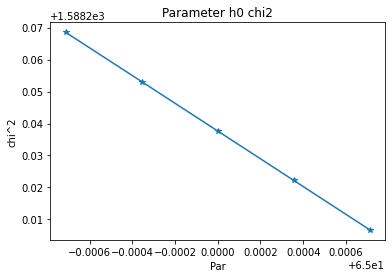

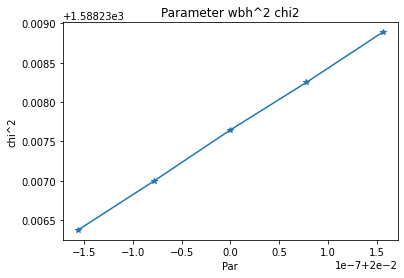

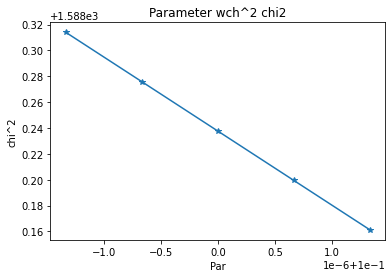

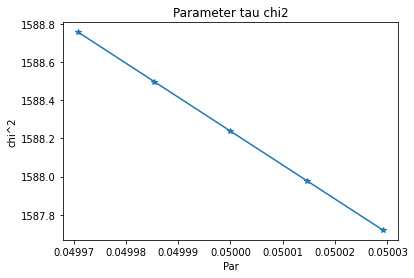

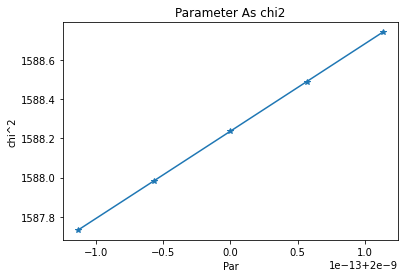

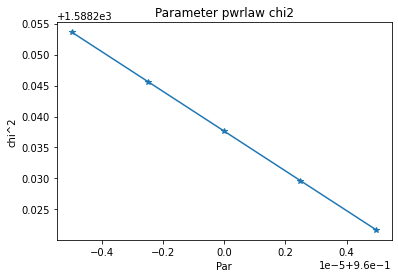

In [14]:
#plot the chi^2
for jj in range(len(pars0)): #run through all the parameters
    mpl.figure()
    mpl.plot(pars0[jj]+dx0[jj]*np.arange(-2, 3), chi[jj, :], '*-')
    mpl.title('Parameter ' + par_lab[jj] + ' chi2')
    mpl.xlabel('Par')
    mpl.ylabel('chi^2')
    mpl.show()

#chi^2 changing linearly at the points expanded around the main point.
#If chi^2 is behaving in a sane, linear fashion, then the derivatives will be too, as they are meant to
#follow the gradiant of chi^2 downhill.

In [17]:
print(lhs)
test = np.loadtxt('newton_lhs.txt')
print(lhs - test)
# np.savetxt('newton_lhs.txt', lhs)


[[ 2.28897874e+00 -3.63692395e+03  1.21642860e+03  2.10092100e+02
  -5.24226027e+10  2.89523302e+01]
 [-3.63692395e+03  1.78912044e+07 -1.95362787e+06 -2.24588757e+05
   5.69883758e+13 -4.55535320e+05]
 [ 1.21642860e+03 -1.95362787e+06  1.77853961e+06  6.51338381e+05
  -1.64411195e+14  1.70050907e+05]
 [ 2.10092100e+02 -2.24588757e+05  6.51338381e+05  2.88230050e+05
  -7.28411610e+13  7.08627604e+04]
 [-5.24226027e+10  5.69883758e+13 -1.64411195e+14 -7.28411610e+13
   1.84193154e+22 -1.81667834e+13]
 [ 2.89523302e+01 -4.55535320e+05  1.70050907e+05  7.08627604e+04
  -1.81667834e+13  4.05613077e+04]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


Hi, sorry, I think I must have got mixed up with Problems 4 and 5, which are great for corner plots.
For problem 3, when it's asking about the derivatives, I asked Sievers in office hours and he was saying that something like: pick a point, take a couple points around it by varying a single parameter (at steps smaller than the newtons method steps, so you're away from the minimum, so things stay a more linear rather than quadratic), and collapse down the data into chi2. then plotting the chi2 for those steps around the points should show the chi2 moving in a sane linear-ish fashion decreasing.
And then doing one of those plots for each of the parameters.